<a href="https://colab.research.google.com/github/MohamedKhalidmk/DeepLearning/blob/main/Rock_Paper_Scissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, losses, optimizers
import pandas as pd

In [32]:
(train_full, test), info = tfd.load('rock_paper_scissors', split=['train', 'test'], as_supervised=True, with_info=True) # Load the Rock-Paper-Scissors dataset from TensorFlow Datasets
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='/root/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock

In [33]:
IMG_size=300
train_full = tfd.load('rock_paper_scissors', split='train[:90%]', as_supervised=True) #split train into training and validation
val_full = tfd.load('rock_paper_scissors', split='train[90%:]', as_supervised=True)
def preprocessing(img, label):
   print(f"{img.shape}")
   image=tf.image.resize(img, (IMG_size, IMG_size))
   image=tf.cast(image, tf.float32)/255.0
   return image, label
train = train_full.map(preprocessing).cache().shuffle(1000).batch(32)# Preprocess and prepare the training dataset
val = val_full.map(preprocessing).cache().batch(32)
test = test.map(preprocessing).cache().batch(32)
print(f"training dataset batch size: {train_full.cardinality()}")
print(f"Validation dataset batch size: {val.cardinality()}")

(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
training dataset batch size: 2268
Validation dataset batch size: 8


In [39]:
optimizer_list={                                #optimizers
    'sgd':optimizers.SGD(learning_rate=0.01),
    'momentum':optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'nesterov':optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    'adagrad':optimizers.Adagrad(learning_rate=0.01),
    'rmsprop':optimizers.RMSprop(learning_rate=0.001),
    'adam':optimizers.Adam(learning_rate=0.001),
}


In [40]:
def mlp(optimizer):  #mlp model
  model=models.Sequential([
    layers.Input(shape=(IMG_size,IMG_size,3,)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
  ])
  model.compile(optimizer=optimizer, loss=losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['acc'])
  return model


In [41]:
history_mlp={}
best_model=None
best_optimizer=""
best_acc=0
for name,opt in optimizer_list.items():
  print(f"Training with {name}")
  model=mlp(opt)
  hist= model.fit(train, validation_data=val, epochs=5, verbose=1)
  history_mlp[name]=hist.history
  current_mode_acc=max(hist.history['val_acc'])
  if best_model is None or current_mode_acc>best_acc:
    best_model=model
    best_acc=current_mode_acc
    best_optimizer=name
print(f"Best optimizer:{best_optimizer}")


Training with sgd
Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - acc: 0.3422 - loss: 43.6047 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - acc: 0.3284 - loss: 1.0988 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - acc: 0.3139 - loss: 1.0987 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - acc: 0.3397 - loss: 1.0987 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - acc: 0.3435 - loss: 1.0986 - val_acc: 0.3333 - val_loss: 1.0986
Training with momentum
Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - acc: 0.3345 - loss: 148.8728 - val_acc: 0.3333 - val_loss: 1.1014
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - acc: 0.3187 - loss: 1.1014 - val_acc: 0.3333 - val_loss: 1.0991
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.3170 - loss: 1.0995 - val_acc: 0.3333 - val_loss: 1.0987
Epoch 4/5
71/71 ━━━━━━━━━━━━

In [42]:
for name, hist in history_mlp.items():
    print("=" * 50)
    for epoch in range(len(hist['loss'])):
        training_loss = hist['loss'][epoch]
        training_acc = hist['acc'][epoch]
        val_loss = hist['val_loss'][epoch]
        val_acc = hist['val_acc'][epoch]

        print(f"Epoch {epoch+1}:")
        print(f"  🔹 Training Loss: {training_loss:.4f}")
        print(f"  🔹 Training Accuracy: {training_acc:.4f}")
        print(f"  🔸 Validation Loss: {val_loss:.4f}")
        print(f"  🔸 Validation Accuracy: {val_acc:.4f}")


Epoch 1:
  🔹 Training Loss: 16.5673
  🔹 Training Accuracy: 0.3316
  🔸 Validation Loss: 1.0986
  🔸 Validation Accuracy: 0.3333
Epoch 2:
  🔹 Training Loss: 1.0987
  🔹 Training Accuracy: 0.3276
  🔸 Validation Loss: 1.0986
  🔸 Validation Accuracy: 0.3333
Epoch 3:
  🔹 Training Loss: 1.0988
  🔹 Training Accuracy: 0.3148
  🔸 Validation Loss: 1.0986
  🔸 Validation Accuracy: 0.3333
Epoch 4:
  🔹 Training Loss: 1.0987
  🔹 Training Accuracy: 0.3302
  🔸 Validation Loss: 1.0986
  🔸 Validation Accuracy: 0.3333
Epoch 5:
  🔹 Training Loss: 1.0987
  🔹 Training Accuracy: 0.3333
  🔸 Validation Loss: 1.0986
  🔸 Validation Accuracy: 0.3333
Epoch 1:
  🔹 Training Loss: 51.0082
  🔹 Training Accuracy: 0.3536
  🔸 Validation Loss: 1.1014
  🔸 Validation Accuracy: 0.3333
Epoch 2:
  🔹 Training Loss: 1.1005
  🔹 Training Accuracy: 0.3144
  🔸 Validation Loss: 1.0991
  🔸 Validation Accuracy: 0.3333
Epoch 3:
  🔹 Training Loss: 1.0992
  🔹 Training Accuracy: 0.3214
  🔸 Validation Loss: 1.0987
  🔸 Validation Accuracy: 0.333

In [43]:
test_loss, test_acc=best_model.evaluate(test)
print(f"Test loss:{test_loss}\nTest accuracy:{test_acc}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - acc: 0.5870 - loss: 5.4995
Test loss:5.849196434020996
Test accuracy:0.5833333134651184


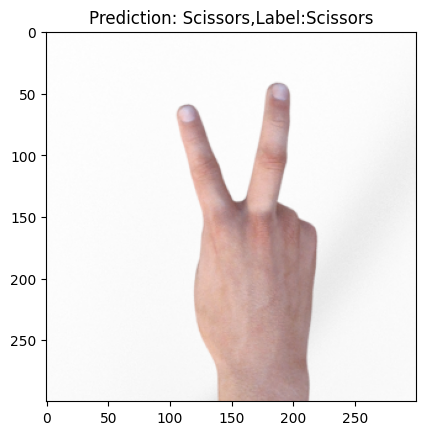

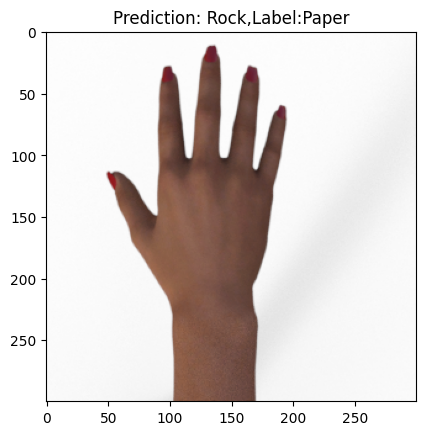

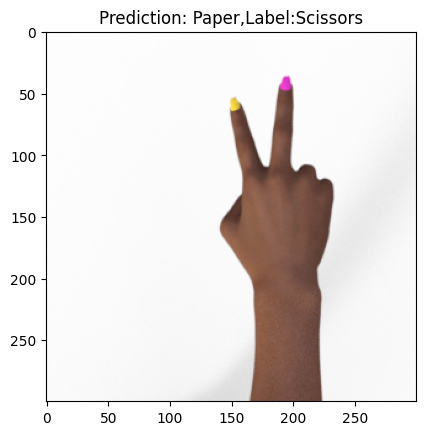

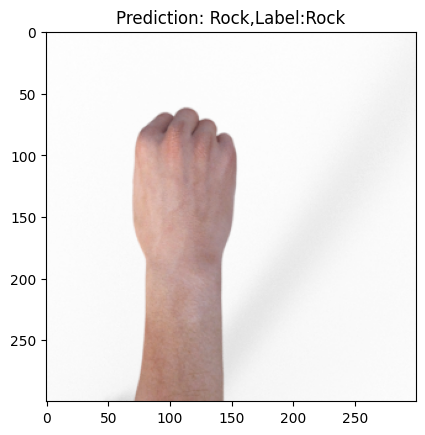

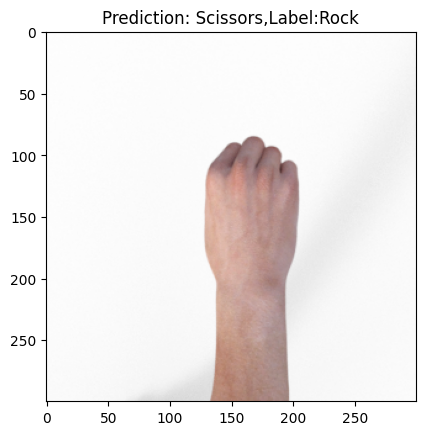

In [44]:
class_label=['Rock','Paper','Scissors']    #example output
for image,label in test.unbatch().take(5):
  img=image.numpy()
  label=label.numpy()
  img_reshaped=tf.expand_dims(image, 0)
  prediction=model.predict(img_reshaped,verbose=0)
  prediction_label=np.argmax(prediction)
  plt.imshow(img)
  plt.title(f"Prediction: {class_label[prediction_label]},Label:{class_label[label]}")
  plt.show()


In [7]:
def cnn(optimizer): #CNN model
  model=models.Sequential([
    layers.Input(shape=(IMG_size,IMG_size,3,)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
  ])
  model.compile(optimizer=optimizer, loss=losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['acc'])
  return model



In [21]:
history_cnn = {}
best_models = []
best_acc = 0

for name, optimizer in optimizer_list.items():
    print(f"Training with {name}")
    model = cnn(optimizer)
    hist = model.fit(train, validation_data=val, epochs=5, verbose=1)
    history_cnn[name] = hist.history

    current_val_acc = max(hist.history.get('val_accuracy', hist.history.get('val_acc')))

    if current_val_acc > best_acc:
        best_models = [(name, model, current_val_acc)]
        best_acc = current_val_acc
    elif current_val_acc == best_acc:
        best_models.append((name, model, current_val_acc))

print("\n🔥 Best models (based on highest val accuracy):")
for opt_name, _, acc in best_models:
    print(f"- Optimizer: {opt_name}, Val Accuracy: {acc:.4f}")


Training with sgd
Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - acc: 0.3781 - loss: 1.0906 - val_acc: 0.3849 - val_loss: 1.0360
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - acc: 0.4972 - loss: 1.0062 - val_acc: 0.4444 - val_loss: 0.9831
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - acc: 0.6413 - loss: 0.8243 - val_acc: 0.7341 - val_loss: 0.7234
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - acc: 0.8269 - loss: 0.5350 - val_acc: 0.8968 - val_loss: 0.2999
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - acc: 0.9316 - loss: 0.2479 - val_acc: 0.9921 - val_loss: 0.0611
Training with momentum
Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - acc: 0.4147 - loss: 1.0660 - val_acc: 0.5556 - val_loss: 0.8511
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - acc: 0.6224 - loss: 0.9471 - val_acc: 0.8690 - val_loss: 0.2330
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - acc: 0.9512 - loss: 0.1426 - val_acc: 0.9921 - val_loss: 0.0555
Epoch 4/5
71/71 ━━━━━━━━━━━

In [22]:
for name, hist in history_cnn.items():
    print("=" * 50)
    for epoch in range(len(hist['loss'])):
        training_loss = hist['loss'][epoch]
        training_acc = hist['acc'][epoch]
        val_loss = hist['val_loss'][epoch]
        val_acc = hist['val_acc'][epoch]

        print(f"Epoch {epoch+1}:")
        print(f"  🔹 Training Loss: {training_loss:.4f}")
        print(f"  🔹 Training Accuracy: {training_acc:.4f}")
        print(f"  🔸 Validation Loss: {val_loss:.4f}")
        print(f"  🔸 Validation Accuracy: {val_acc:.4f}")


Epoch 1:
  🔹 Training Loss: 1.0675
  🔹 Training Accuracy: 0.4334
  🔸 Validation Loss: 1.0360
  🔸 Validation Accuracy: 0.3849
Epoch 2:
  🔹 Training Loss: 0.9687
  🔹 Training Accuracy: 0.5441
  🔸 Validation Loss: 0.9831
  🔸 Validation Accuracy: 0.4444
Epoch 3:
  🔹 Training Loss: 0.7733
  🔹 Training Accuracy: 0.6759
  🔸 Validation Loss: 0.7234
  🔸 Validation Accuracy: 0.7341
Epoch 4:
  🔹 Training Loss: 0.4421
  🔹 Training Accuracy: 0.8514
  🔸 Validation Loss: 0.2999
  🔸 Validation Accuracy: 0.8968
Epoch 5:
  🔹 Training Loss: 0.1594
  🔹 Training Accuracy: 0.9603
  🔸 Validation Loss: 0.0611
  🔸 Validation Accuracy: 0.9921
Epoch 1:
  🔹 Training Loss: 1.0075
  🔹 Training Accuracy: 0.4991
  🔸 Validation Loss: 0.8511
  🔸 Validation Accuracy: 0.5556
Epoch 2:
  🔹 Training Loss: 0.6920
  🔹 Training Accuracy: 0.7108
  🔸 Validation Loss: 0.2330
  🔸 Validation Accuracy: 0.8690
Epoch 3:
  🔹 Training Loss: 0.1225
  🔹 Training Accuracy: 0.9630
  🔸 Validation Loss: 0.0555
  🔸 Validation Accuracy: 0.9921


In [25]:
for name, model,_ in best_models:
    test_loss, test_acc = model.evaluate(test, verbose=0)
    print(f"\n🧪 Testing results for optimizer '{name}':")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")


🧪 Testing results for optimizer 'momentum':
Test Loss: 0.6581
Test Accuracy: 0.8360

🧪 Testing results for optimizer 'adagrad':
Test Loss: 0.8201
Test Accuracy: 0.7366

🧪 Testing results for optimizer 'rmsprop':
Test Loss: 1.4669
Test Accuracy: 0.7581

🧪 Testing results for optimizer 'adam':
Test Loss: 1.4173
Test Accuracy: 0.8065


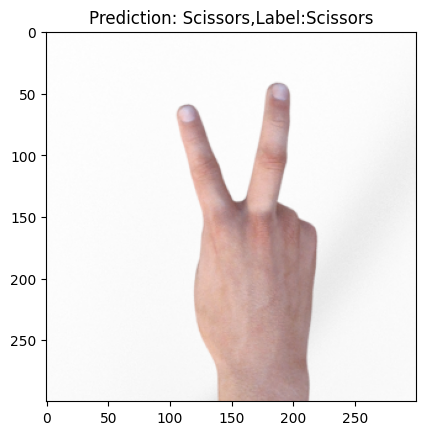

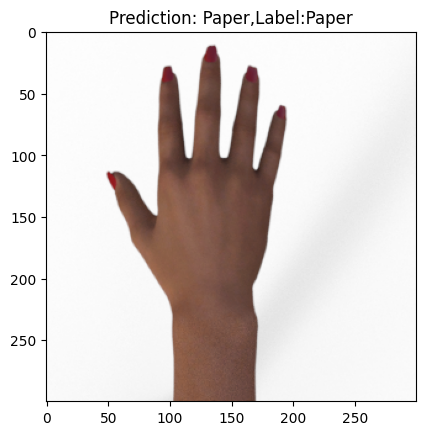

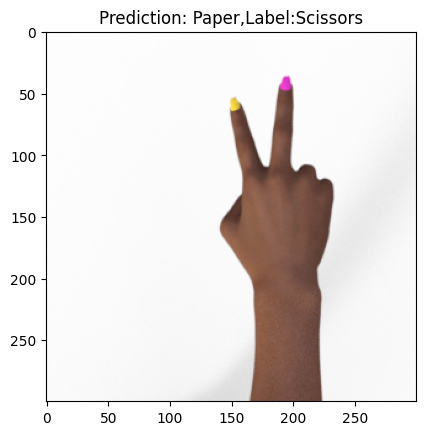

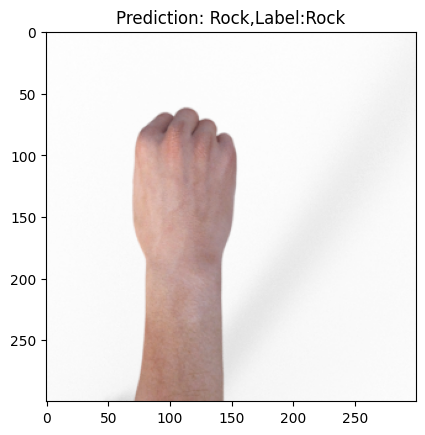

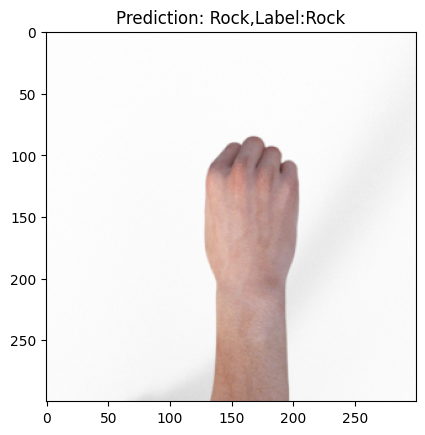

In [30]:
momentum_model = next((m for n, m, a in best_models if n == 'momentum'))
class_label=['Rock','Paper','Scissors']
for img,label in test.unbatch().take(5):
  img=img.numpy()
  img_reshaped=tf.expand_dims(img, 0)
  prediction=momentum_model.predict(img_reshaped,verbose=0)
  prediction_label=np.argmax(prediction)
  plt.imshow(img)
  plt.title(f"Prediction: {class_label[prediction_label]},Label:{class_label[label]}")
  plt.show()

In [61]:
# Labels for rows
row_labels = [
    "MLP Train Loss", "MLP Train Accuracy", "MLP Val Loss", "MLP Val Accuracy",
    "CNN Train Loss", "CNN Train Accuracy", "CNN Val Loss", "CNN Val Accuracy"
]

# Initialize table with row labels
table_data = {"Metric": row_labels}

# Fill the table with each optimizer’s final results
for opt in history_mlp.keys():
    mlp_hist = history_mlp[opt]
    cnn_hist = history_cnn[opt]

    mlp_last = len(mlp_hist['loss']) - 1
    cnn_last = len(cnn_hist['loss']) - 1

    # Ensure all values are numeric before adding to table_data
    table_data[opt.upper()] = [
        round(float(mlp_hist['loss'][mlp_last]), 4),
        round(float(mlp_hist.get('accuracy', mlp_hist.get('acc'))[mlp_last]), 4),
        round(float(mlp_hist['val_loss'][mlp_last]), 4),
        round(float(mlp_hist.get('val_accuracy', mlp_hist.get('val_acc'))[mlp_last]), 4),

        round(float(cnn_hist['loss'][cnn_last]), 4),
        round(float(cnn_hist.get('accuracy', cnn_hist.get('acc'))[cnn_last]), 4),
        round(float(cnn_hist['val_loss'][cnn_last]), 4),
        round(float(cnn_hist.get('val_accuracy', cnn_hist.get('val_acc'))[cnn_last]), 4),
    ]

# Create the DataFrame
df = pd.DataFrame(table_data)


numeric_columns = df.columns[1:]  # Exclude the 'Metric' column
styled_df = df.style.set_caption("Final Evaluation Metrics (MLP vs CNN)") \
                    .set_table_styles([{
                        'selector': 'caption',
                        'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]
                    }]) \
                    .format(precision=4, subset=numeric_columns)

styled_df


,Metric,SGD,MOMENTUM,NESTEROV,ADAGRAD,RMSPROP,ADAM
0,MLP Train Loss,1.0987,1.0993,1.0997,0.8774,7.8305,2.4226
1,MLP Train Accuracy,0.3333,0.3126,0.3307,0.5520,0.4211,0.7901
2,MLP Val Loss,1.0986,1.0987,1.0987,0.8291,5.5865,0.6947
3,MLP Val Accuracy,0.3333,0.3333,0.3333,0.5992,0.3333,0.8651
4,CNN Train Loss,0.1594,0.0225,1.1002,0.0089,0.0000,0.0001
5,CNN Train Accuracy,0.9603,0.9943,0.3197,0.9987,1.0000,1.0000
6,CNN Val Loss,0.0611,0.0021,1.1005,0.0051,0.0000,0.0000
7,CNN Val Accuracy,0.9921,1.0000,0.3333,1.0000,1.0000,1.0000
